# M.Tech (Online) - DSBA DA-231-O (3:1) (Data Engineering at Scale)

## Restaurant Data Storytelling and predictive analysis for new restaurants

| Name | Student Email | 
| :- | :- |   
| Ashish Kumar Singh | ashishsk@iisc.ac.in | 
| Anurodh Jain | anurodhjain@iisc.ac.in | 
| Hariprasad Shenai | hariprasadsk@iisc.ac.in | 
| Keerthivasan Rangarajan | keerthivasan@iisc.ac.in | 

Sections

✔️ Exploratory Data Analysis

✔️ Visualization

✔️ Rate Prediction

✔️ Sentiment Analysis of Reviews

✔️ Recommendation System

## <b>Collab Environment - Setup</b>

In [218]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [219]:
#######################################
###!@0 START INIT ENVIRONMENT
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark_dist_explore
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

###!@0 END INIT ENVIRONMENT

In [220]:
#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!

###!@1 END OF PYSPARK INIT

In [221]:
#######################################
###!@2 START OF DEFINING INPUT FILES
datafile = "/content/drive/MyDrive/Zomato/zomato.csv"

###!@2 END OF DEFINING INPUT FILES

#######################################
###!@3 START OF LOADING DATA

##########################
# load zomato data from CSV
#zdf = spark.read.option("header",True).option("inferSchema",True).csv(datafile)
zdf = (spark.read
      .option("multiline", "true")
      .option("quote", '"')
      .option("header", "true")
      .option("escape", "\\")
      .option("escape", '"')
      .csv(datafile)
)

zdf.printSchema()
zdf.show(2)
#print (zdf.count())

###!@3 END OF LOADING DATA

root
 |-- url: string (nullable = true)
 |-- address: string (nullable = true)
 |-- name: string (nullable = true)
 |-- online_order: string (nullable = true)
 |-- book_table: string (nullable = true)
 |-- rate: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- phone: string (nullable = true)
 |-- location: string (nullable = true)
 |-- rest_type: string (nullable = true)
 |-- dish_liked: string (nullable = true)
 |-- cuisines: string (nullable = true)
 |-- approx_cost(for two people): string (nullable = true)
 |-- reviews_list: string (nullable = true)
 |-- menu_item: string (nullable = true)
 |-- listed_in(type): string (nullable = true)
 |-- listed_in(city): string (nullable = true)

+--------------------+--------------------+--------------+------------+----------+-----+-----+--------------------+------------+-------------+--------------------+--------------------+---------------------------+--------------------+---------+---------------+---------------+
|          

## Data Description 

<ul>
<li><b>url </b>: contains the url of the restaurant in the zomato website
<li><b>address</b>: contains the address of the restaurant in Bengaluru
<li><b>name</b>: contains the name of the restaurant
<li><b>online_order</b>: whether online ordering is available in the restaurant or not
<li><b>book_table</b>: table book option available or not
<li><b>rate</b>: contains the overall rating of the restaurant out of 5
<li><b>votes</b>: contains total number of rating for the restaurant as of the above mentioned date
<li><b>phone</b>: contains the phone number of the restaurant
<li><b>location</b>: contains the neighborhood in which the restaurant is located
<li><b>rest_type</b>: restaurant type
<li><b>dish_liked</b>: dishes people liked in the restaurant
<li><b>cuisines</b>: food styles, separated by comma
<li><b>approx_cost(for two people)</b>: contains the approximate cost for meal for two people
<li><b>reviews_list</b>: list of tuples containing reviews for the restaurant, each tuple
<li><b>menu_item contains</b>: list of menus available in the restaurant
<li><b>listed_in(type)</b>: type of meal
<li><b>listed_in(city)</b>: contains the neighborhood in which the restaurant is listed# New section

In [222]:
#######################################
###!@4 START BASE IMPORTS
#ML libs
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, HashingTF, IDF, Tokenizer, StringIndexer, RFormula
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.classification import LogisticRegression
#SQL libs
from pyspark.sql.functions import col, collect_list, collect_set, max, split, mean, expr, udf
from pyspark.sql.types import *
###!@4 BASE IMPORTS

In [223]:
#######################################
###!@5 START COMMON USER IMPORTS
#######################################
## Specify valid imports, if any, for ALL your answers  ==========
## start your edits here =================
import pyspark.sql.functions as F
from pyspark.sql.functions import * 

# Visualization libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
from pyspark_dist_explore import hist

#word libs
import collections
import re
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#Geo Lib
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import numpy as np
   
## end your edits here =================
###!@5 END COMMON USER IMPORTS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Creating final DataFrame for the further Analysis

In [224]:
mod_zdf_inter = zdf.drop("url","phone").replace(["-","NEW"],[None,"0.0"],"rate").withColumnRenamed("rate","rate")
split_rate = split(mod_zdf_inter["rate"], '/')
mod_zdf = mod_zdf_inter.withColumn("rate", split_rate.getItem(0).cast(DoubleType()))

mod_zdf_listed=mod_zdf.select("address","name","location","listed_in(type)","listed_in(city)", "rest_type", "dish_liked", "cuisines").groupBy("address","name","location")\
.agg(collect_set("listed_in(city)").alias("listed_in_city"), collect_set("listed_in(type)").alias("listed_in_type"), collect_set("rest_type").alias("rest_type")\
,collect_set("dish_liked").alias("dish_liked"), collect_set("cuisines").alias("cuisines"))


mod_zdf_votes=mod_zdf.drop("listed_in(type)","listed_in(city)").groupBy("address","name","location")\
.agg(max("votes").alias("votes"),max("reviews_list").alias("reviews_list")\
, max("menu_item").alias("menu_item"), max("rate").alias("rate")\
, max("online_order").alias("online_order")\
, max("approx_cost(for two people)").alias("approx_cost")\
, max("book_table").alias("book_table"))

zdf_joined=mod_zdf.drop("listed_in(type)","listed_in(city)","reviews_list","menu_item","rest_type","rate", "votes", "online_order","dish_liked", "cuisines", "approx_cost(for two people)", "book_table")\
.join(mod_zdf_votes, ["address","name","location"])\
.join(mod_zdf_listed, ["address","name","location"]).distinct()
zdf_joined= zdf_joined.withColumn("approx_cost", F.regexp_replace(F.col('approx_cost'), ',', '').cast('integer')).\
withColumn("votes", F.regexp_replace(F.col('votes'), ',', '').cast('integer'))
zdf_joined=zdf_joined.withColumn("rest_type",F.concat_ws(",",col("rest_type"))).withColumn("rest_type", F.trim(col("rest_type")))

zdf_joined.show(10)
zdf_joined.cache()
print ("Total count for Domato Dataframe",zdf_joined.count())

+--------------------+--------------------+--------------------+-----+--------------------+---------+----+------------+-----------+----------+--------------------+--------------------+------------------+--------------------+--------------------+
|             address|                name|            location|votes|        reviews_list|menu_item|rate|online_order|approx_cost|book_table|      listed_in_city|      listed_in_type|         rest_type|          dish_liked|            cuisines|
+--------------------+--------------------+--------------------+-----+--------------------+---------+----+------------+-----------+----------+--------------------+--------------------+------------------+--------------------+--------------------+
|1, 100 Feet Ring ...|              Al-Bek|                 BTM|  188|[('Rated 3.0', 'R...|       []| 3.9|         Yes|        450|        No|[Jayanagar, BTM, ...|          [Delivery]|Takeaway, Delivery|[Naan, Mutton Bir...|[Biryani, North I...|
|1, Chandru Comp

## <b>1. Exploratory Data Analysis </b>#

# Restaurant Count By Location

Text(0.5, 1.0, 'Restaurant Count By Location')

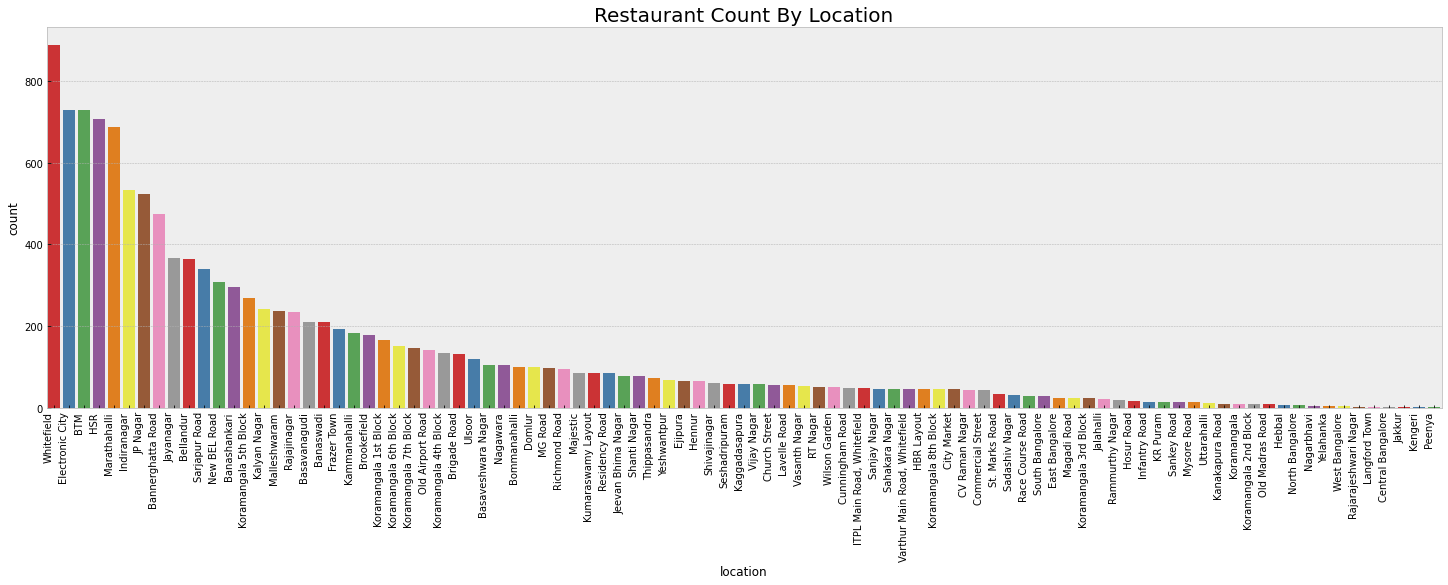

In [225]:
data = zdf_joined.select("location").toPandas()
rcParams['figure.figsize'] = 25,7
g = sns.countplot(x="location",data=data, palette = "Set1", order=data['location'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
plt.title('Restaurant Count By Location',size = 20)

# Word cloud

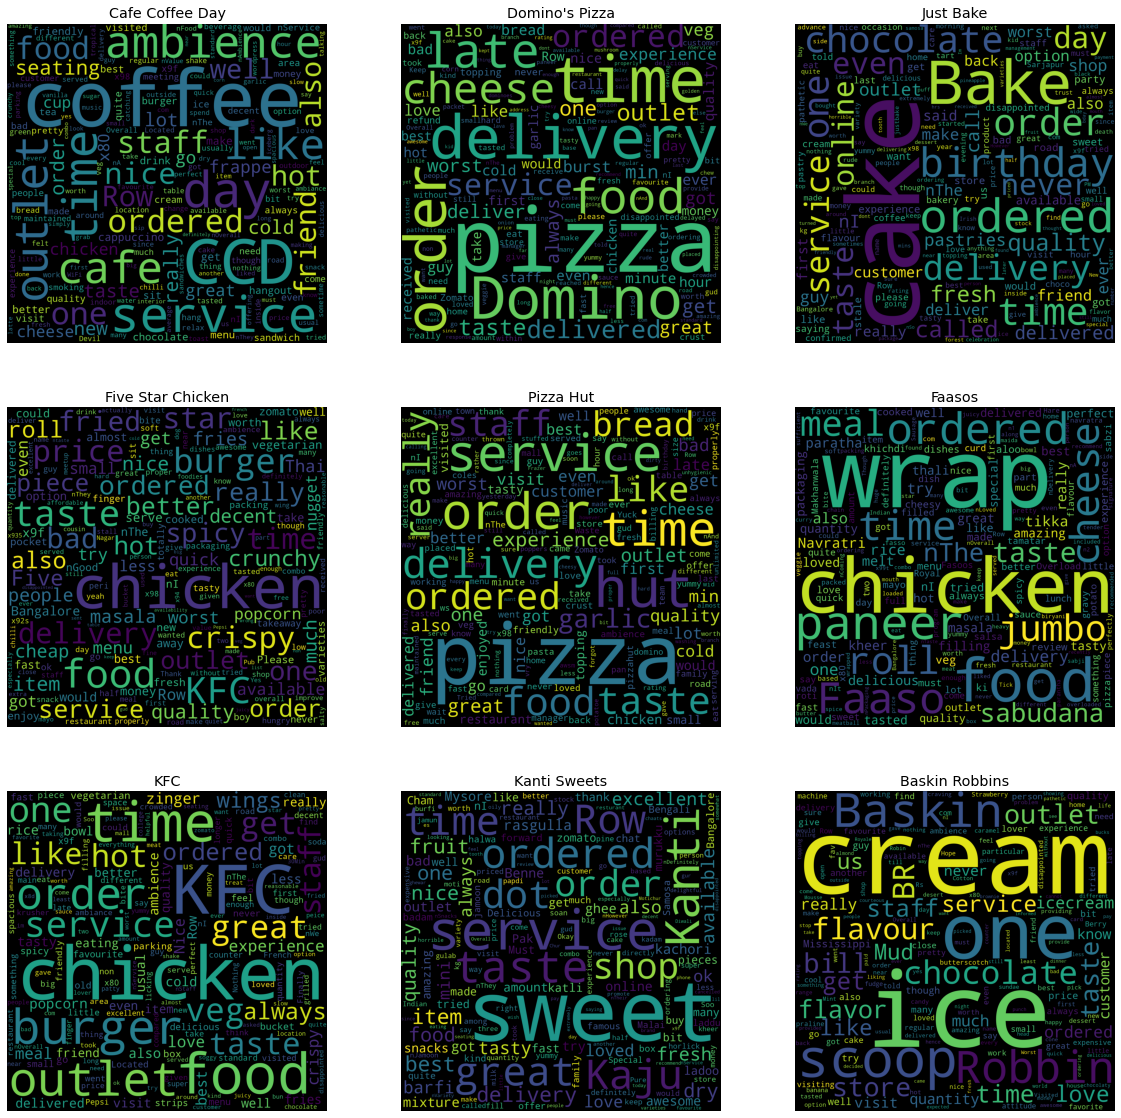

In [226]:
#First, we get the top chain restaurant names. Top is based on the number of chains in Bangalore.
top_chains_df=zdf_joined.groupBy("name").count().orderBy("count", ascending=False).head(9)
top_chains=([row.name for row in top_chains_df])

revdf = zdf_joined.select("name","reviews_list").where(col("name").isin(top_chains))#.filter(col("reviews_list").isNotNull())

plt.figure(figsize=(20,20))

for i,name in enumerate(top_chains):
  plt.subplot(3,3,i+1)

  #We are converting the datafrome to str datatype so that we could give it as input in word cloud.
  cldf = revdf.where(col("name")==name).withColumn("reviews_list", F.regexp_replace("reviews_list", "[^0-9a-zA-Z$]+" , " "))
  obj = cldf.select("reviews_list").collect()
  objs = ' '.join([str(elem) for elem in obj])


  stop = set(stopwords.words('english'))
  stop.update(["RATED", "rated", "reviews_list","x82", "x83", "x92t", "x92","place","good"])
  wordcloud = WordCloud(width=1500, height=1500,max_font_size=None, collocations=False,stopwords=stop).generate(objs)
  #plt.figure(figsize=(12,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(name)
  #plt.show()

#This runs for 1m 45s 

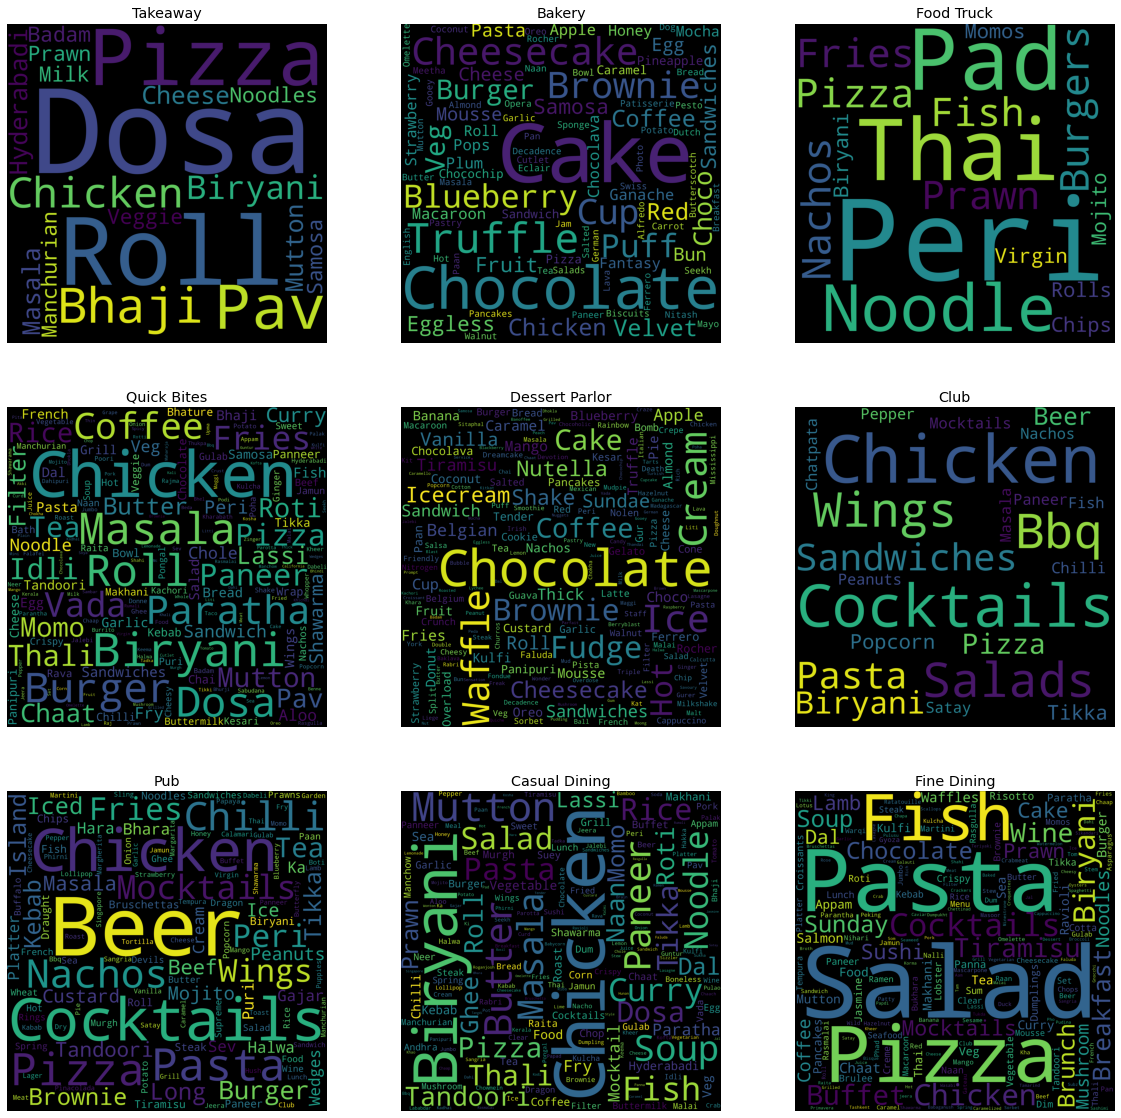

In [227]:
#Function to flatten and prepare the unique list of restaurant types.
zdf_joineds=zdf_joined.withColumn("dish_liked",F.concat_ws(",",col("dish_liked"))).withColumn("dish_liked", F.trim(col("dish_liked")))
def flatten(x):
    if isinstance(x, list):
        return [a for i in x for a in flatten(i)]
    else:
        return [x.strip()]

#Code to get Restaurant Type unique List
rest_type=zdf_joineds.select("rest_type").agg(collect_set("rest_type").alias("rest_type")).collect()
rest_types = ([row.rest_type for row in rest_type])
rest_flat=([x.split(",") for x in flatten(rest_types)])
rest_type_list=list(set(flatten(rest_flat)))


#We have the restaurant types from  rest_type_list param. 
j=1
rest_zdf = zdf_joineds.select("name","rest_type","dish_liked").where(F.length(col("dish_liked")) > 0)#.withColumn("dish_liked", F.regexp_replace("dish_liked", "\\s+", ""))
# rest_zdf.where(col("name")=="CakeZone").show()

plt.figure(figsize=(20,20))

for i,rest in enumerate(rest_type_list):
  #The below logics are to ignore null rest type and to restrict the word cloud number to 9.
  if len(rest)==0:
    continue
  if j>9:
    break
  #We are converting the datafrome to str datatype so that we could give it as input in word cloud.
  cldf = rest_zdf.where(col("rest_type").isin(rest)).where(col("dish_liked").isNotNull())
  #cldf.show()
  obj = cldf.select("dish_liked").collect()
  dish_string=([str(elem.dish_liked) for elem in obj])
  objs = ' '.join(dish_string)
  #print(objs)
  if objs: 
    plt.subplot(3,3,j)
    stop = set(stopwords.words('english'))
    stop.update(["RATED", "rated", "dish_liked","x82", "x83", "x92t", "x92","place","good","Row"])
    wordcloud = WordCloud(width=2000, height=2000,max_font_size=None, collocations=False,stopwords=stop).generate(objs)
    #plt.figure(figsize=(12,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(rest)
    j+=1

#This ran for 2m

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Rate')

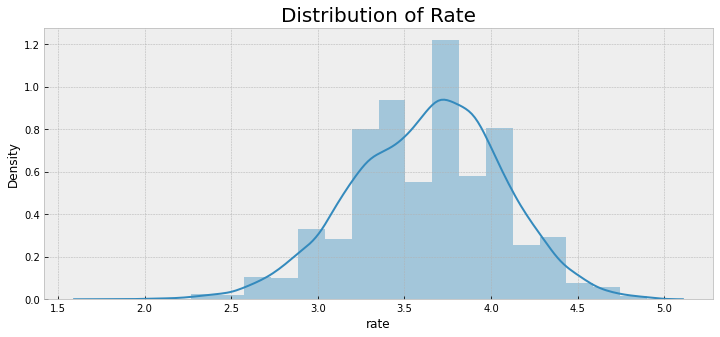

In [228]:
#Rate column's distribution:
plt.figure(figsize=(12,5))
rating = zdf_joined.select("rate").where(col("rate")>0.0).toPandas()
#rating = zdf_joined.select("rate").toPandas()
sns.distplot(x=rating,bins=20)
plt.xlabel('rate')

plt.title("Distribution of Rate",size=20)

## -- Selection of RESTAURANTS on the Budget and LUXURY--
## 1. TOP 10 RESTAURANTS IN BANGALORE 
## 2. TOP 5 LUXURY RESTAURANTS IN BANGALORE
## 3. TOP 5 Budget RESTAURANTS IN BANGALORE

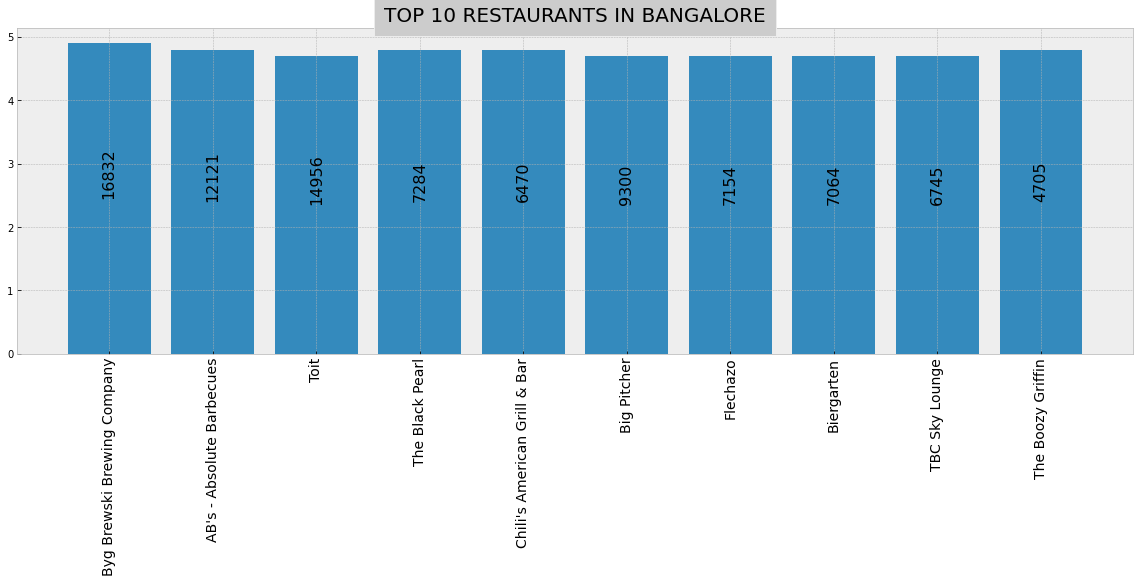

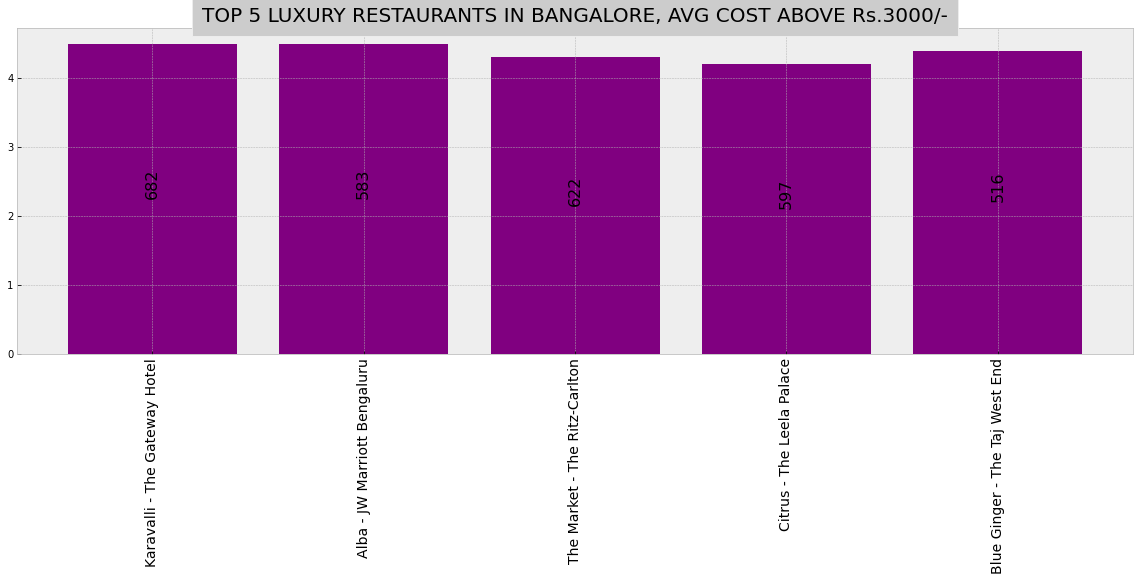

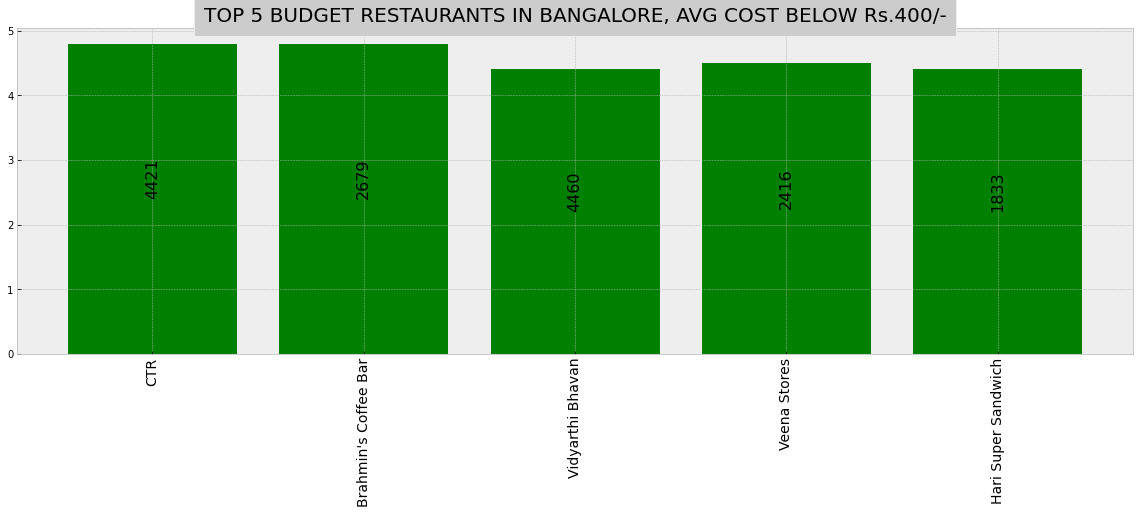

In [229]:
###  Formcula for the calculation
#weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 
#where:
#R = average for the  (mean) = (Rating)
#v = number of votes for the movie = (votes)
#m = minimum votes required to be listed in the Top 250 (currently 500)
#C = the mean vote across the whole report (currently 3.3618)
# votes, rate, approx_cost

rateZdf = zdf_joined.filter(col("rate").isNotNull() & col("votes").isNotNull()).select("name", "rate","votes", "approx_cost")\
          .withColumn("approx_cost", F.regexp_replace(F.col('approx_cost'), ',', '').cast('integer'))
ratingDf = rateZdf.filter(rateZdf.votes > 500)
totMean = rateZdf.select("rate").agg(F.avg("rate")).withColumnRenamed("avg(rate)", "avgrate")
m = totMean.collect()
mean_rate = float(m[0].avgrate)

normRateDf = ratingDf.withColumn("normRate", expr("(votes/(votes+500))*rate+(500/(votes+500))"))
normRateDf = normRateDf.withColumn("nRate", expr("normRate * 3.3618"))
resDf = normRateDf.dropDuplicates(["name"]).cache()

res = resDf.orderBy("nRate", ascending=False).collect()
answer = [(row.name, row.rate, row.votes) for row in res]
top10 = answer[0:10]

### Common User function
def autolabel(rects, label):
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
                label[idx],
                ha='center', va='bottom', rotation=90, fontsize=16)

##------ Bar graph for top 10 restaurants --------##
fig, ax = plt.subplots(figsize=(20,6))
bar_plot = plt.bar(range(len(top10)), [val[1] for val in top10], align='center')
bar_label = [val[2] for val in top10]
autolabel(bar_plot, bar_label)
plt.xticks(range(len(top10)), [val[0] for val in top10])
plt.xticks(rotation=90, fontsize=14)
ax.set_title('TOP 10 RESTAURANTS IN BANGALORE', 
             bbox={'facecolor':'0.8', 'pad':10}, fontsize=20)
plt.show()

top5luxury = resDf.filter(col('approx_cost') > 3000).orderBy("nRate", ascending=False).collect()
answer = [(row.name, row.rate, row.votes) for row in top5luxury]
top5lux = answer[0:5]

##------ Bar graph for top 10 LUXURY restaurants --------##
fig, ax = plt.subplots(figsize=(20,6))
bar_plot = plt.bar(range(len(top5lux)), [val[1] for val in top5lux], align='center', color='purple')
bar_label = [val[2] for val in top5lux]
autolabel(bar_plot, bar_label)
plt.xticks(range(len(top5lux)), [val[0] for val in top5lux])
plt.xticks(rotation=90, fontsize=14)
ax.set_title('TOP 5 LUXURY RESTAURANTS IN BANGALORE, AVG COST ABOVE Rs.3000/-', 
             bbox={'facecolor':'0.8', 'pad':10}, fontsize=20)
#plt.title("TOP 5 LUXURY RESTAURANTS IN BANGALORE, AVG COST ABOVE Rs.3000/-")
plt.show()

topbudget = resDf.filter(col('approx_cost') < 400).orderBy("nRate", ascending=False).collect()
answer = [(row.name, row.rate, row.votes) for row in topbudget]
top5bud = answer[0:5]

##------  Bar graph for top 5 budget restaurants --------##
fig, ax = plt.subplots(figsize=(20,6))
bar_plot = plt.bar(range(len(top5bud)), [val[1] for val in top5bud], align='center', color ='green')
bar_label = [val[2] for val in top5bud]
autolabel(bar_plot, bar_label)
plt.xticks(range(len(top5bud)), [val[0] for val in top5bud])
plt.xticks(rotation=90, fontsize=14)
ax.set_title('TOP 5 BUDGET RESTAURANTS IN BANGALORE, AVG COST BELOW Rs.400/-', 
             bbox={'facecolor':'0.8', 'pad':10}, fontsize=20)
#plt.title("TOP 5 BUDGET RESTAURANTS IN BANGALORE, AVG COST BELOW Rs.400/-")
plt.show()

# New section

## Top 10 dishes in Bangalore

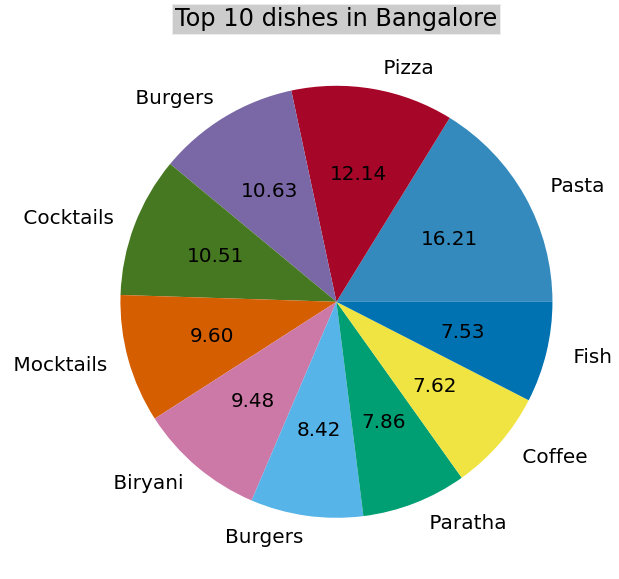

In [230]:
# Top 10 dishes based on Dishes liked column in Dataframe
dishZdf = zdf_joined.where(col('dish_liked').isNotNull())
cuisines_count = {}

def get_cuisines(cuisines):
    for cuisine in cuisines:
      items = cuisine.split(',')
      for food in items:
        if food != "":
          cuisines_count[food] = cuisines_count.get(food,0)+1
    return cuisines

dzdf = dishZdf.select("dish_liked").collect()
answer = [(row.dish_liked) for row in dzdf]
for elem in answer:
  get_cuisines(elem)
count_cuisines = [[value,key] for key,value in cuisines_count.items()]
count_cuisines.sort(reverse=True)
counts = [i[0] for i in count_cuisines][:10]
cuisine_names = [i[1] for i in count_cuisines][:10]
cuisine_list  = [i[1] for i in count_cuisines]

fig = plt.figure(figsize=(15,8))
ax = fig.add_axes((0,0,.5,1))
ax.set_title('Top 10 dishes in Bangalore', 
             bbox={'facecolor':'0.8', 'pad':3}, fontsize=24)
ax.pie(counts,labels=cuisine_names,autopct="%.2f", textprops={'fontsize': 20})
plt.show()
#print (cuisine_list)

# Top dishes Reviewed in specific Restaurant

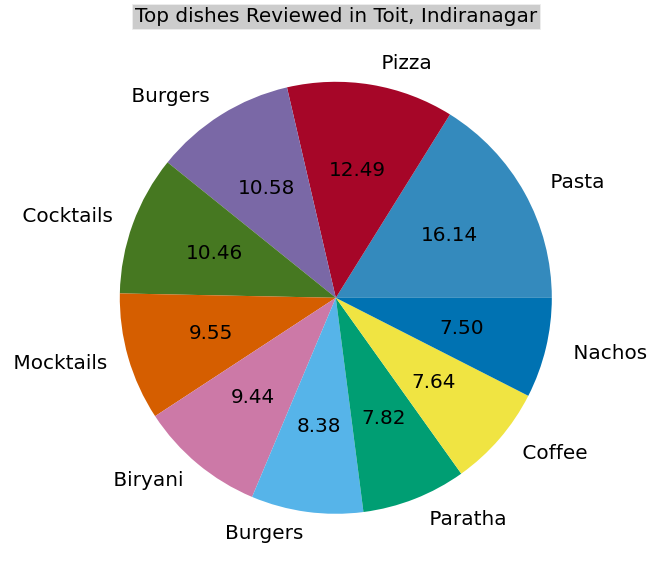

In [231]:
# Find dishes reviewed in reviews list and adds a new column
revDf = zdf_joined.where(col("name") == "Toit")

def build_regex(keywords):
    res = '('
    for key in keywords:
        res += '\\b' + key + '\\b|'
    res = res[0:len(res) - 1] + ')'

    return res

def get_matching_string(line, regex):
    matches = re.findall(regex, line)
    return matches if matches else None

udf_func = udf(lambda line, regex: get_matching_string(line, regex),
               ArrayType(StringType()))

df = revDf.withColumn('dish_reviewed', udf_func(revDf['reviews_list'], F.lit(build_regex(cuisine_list)))).withColumn('count', F.size('dish_reviewed'))
df = df.where(F.size("dish_reviewed") > 0)
dzdf = df.select("dish_reviewed").collect()
#print (dzdf)
answer = [(row.dish_reviewed) for row in dzdf]

for elem in answer:
  get_cuisines(elem)

count_cuisines = [[value,key] for key,value in cuisines_count.items()]
count_cuisines.sort(reverse=True)
counts = [i[0] for i in count_cuisines][:10]
cuisine_names = [i[1] for i in count_cuisines][:10]
cuisine_list  = [i[1] for i in count_cuisines]

fig = plt.figure(figsize=(15,8))
ax = fig.add_axes((0,0,.5,1))
ax.set_title('Top dishes Reviewed in Toit, Indiranagar', 
             bbox={'facecolor':'0.8', 'pad':3}, fontsize=20)
ax.pie(counts,labels=cuisine_names,autopct="%.2f", textprops={'fontsize': 20})

plt.show()

## Analysis for votes vs rating

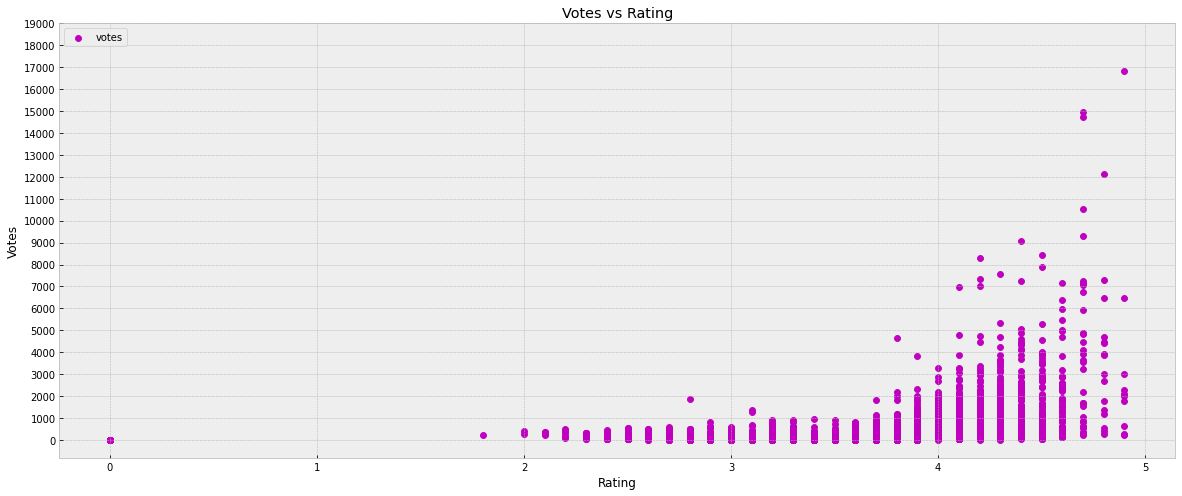

In [232]:
# votes vs rate
y_votes = [val.votes for val in zdf_joined.select('votes').collect()]
x_rates = [val.rate for val in zdf_joined.select('rate').collect()]
y_ticks = [n for n in range(0,20000, 1000)]
figs, axs = plt.subplots(figsize=(20,8))
axs.scatter(x_rates, y_votes, marker='o',color='m')
axs.set_yticks(y_ticks)
plt.ylabel('Votes')
plt.xlabel('Rating')
plt.title('Votes vs Rating')
plt.legend(['votes'], loc='upper left')

plt.show()

## Analysis for Average Cost for 2 based on restaurants rating

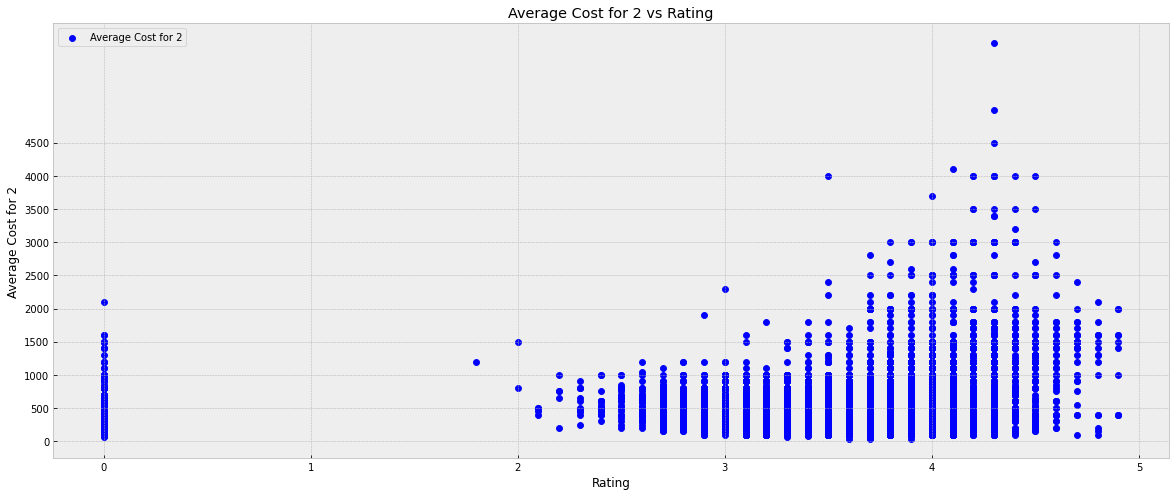

In [233]:
# approx_cost vs rate
#zdf_joinedRate = zdf_joined.withColumn("rating", zdf_joined["rate"].cast(IntegerType()))
y_votes = [val.approx_cost for val in zdf_joined.select('approx_cost').collect()]

x_rate = [val.rate for val in zdf_joined.select(col('rate')).collect()]
y_tick = [n for n in range(0,5000, 500)]
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(x_rate, y_votes, marker='o',color='b')
ax.set_yticks(y_tick)
plt.ylabel('Average Cost for 2')
plt.xlabel('Rating')
plt.title('Average Cost for 2 vs Rating')
plt.legend(['Average Cost for 2'], loc='upper left')

plt.show()

# Analysis of Avg. Restaurant Rating By Location

Text(0.5, 1.0, 'Avg. Restaurant Rating By Location')

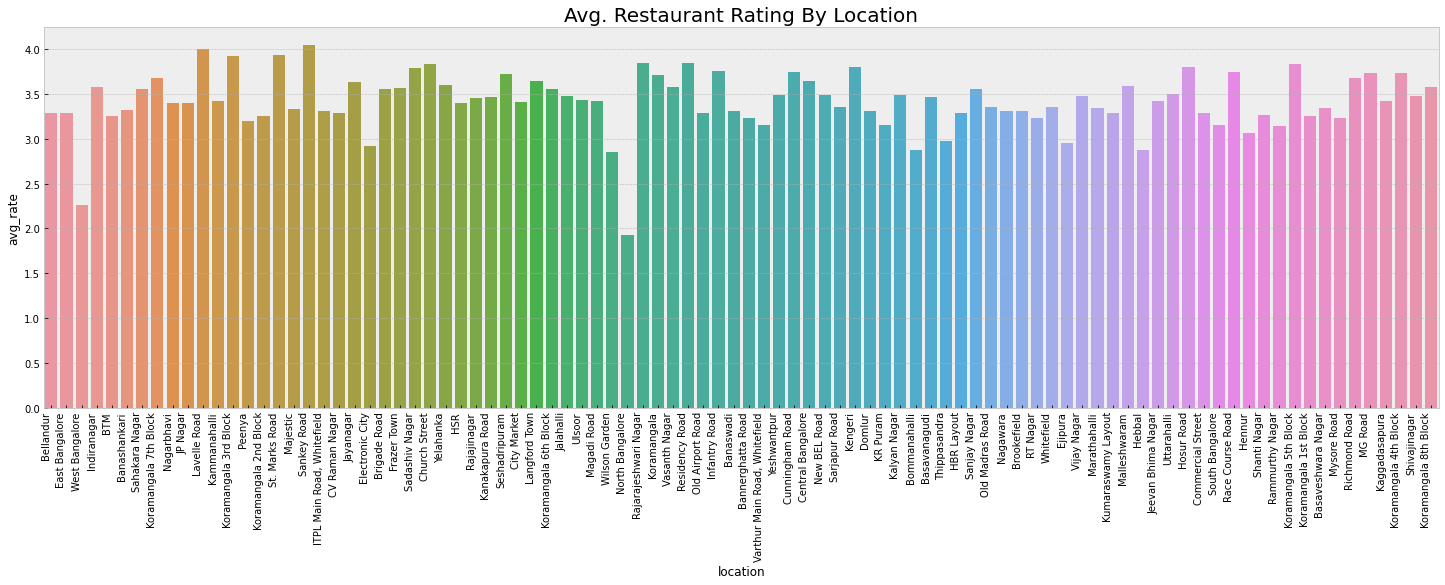

In [234]:
# Group by Location vs Cost
glocDf = zdf_joined.groupBy("location").avg("rate").withColumnRenamed("avg(rate)","avg_rate")
glocDf = glocDf.where(col("avg_rate") > 0)
rcParams['figure.figsize'] = 25,7
data = glocDf.toPandas()
g = sns.barplot(x = 'location', y = 'avg_rate', data = data)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
plt.title('Avg. Restaurant Rating By Location',size = 20)


# Analysis of Avg. Restaurant Cost By Location

Text(0.5, 1.0, 'Avg. Restaurant Cost By Location')

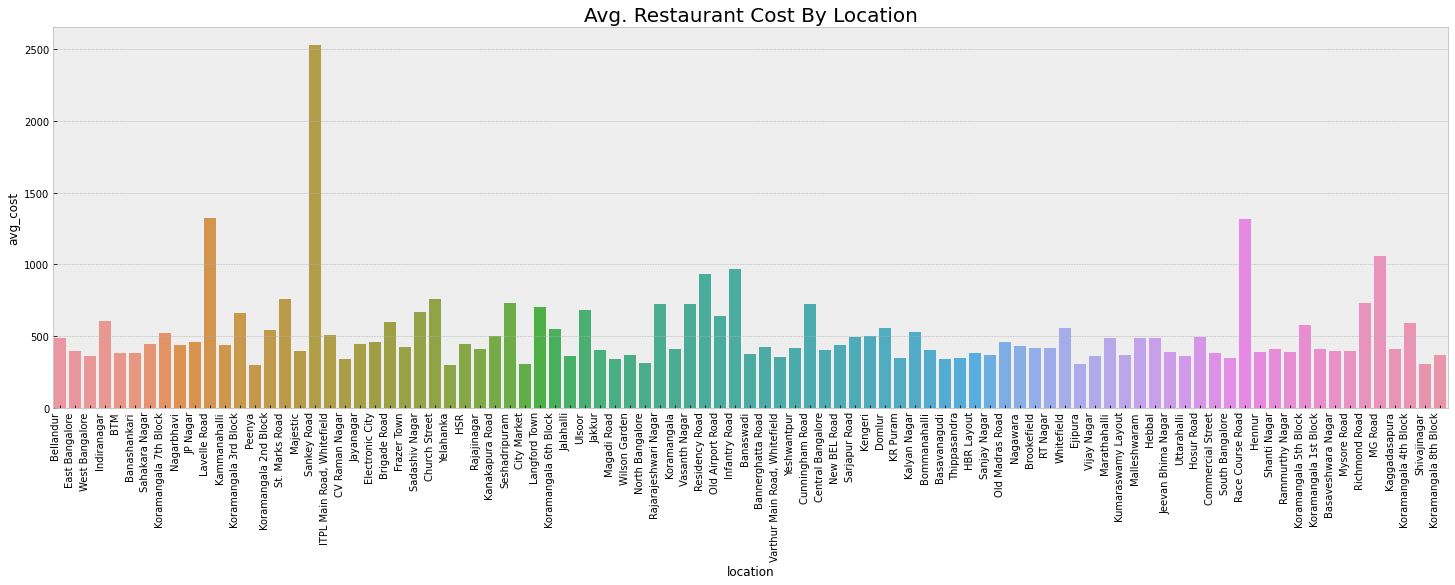

In [235]:
# Group by Location vs Cost
glocDf = zdf_joined.groupBy("location").avg("approx_cost").withColumnRenamed("avg(approx_cost)","avg_cost")

rcParams['figure.figsize'] = 25,7
data = glocDf.toPandas()
g = sns.barplot(x = 'location', y = 'avg_cost', data = data)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
plt.title('Avg. Restaurant Cost By Location',size = 20)


# Geo-spatial Analysis

In [246]:
# declare an empty list to store
# latitude and longitude of values 
# of city column
longitude = []
latitude = []

area = zdf_joined.select('location').distinct().collect()
areas = [(row.location) for row in area]

# function to find the coordinate
# of a given city 
def findGeocode(city): 
    try:
        # Specify the user_agent as your
        # app name it should not be none
        geolocator = Nominatim(user_agent="DS231_project")
        return geolocator.geocode(city)
    except GeocoderTimedOut:  
        return findGeocode(city)    
  
# each value from city column
# will be fetched and sent to
# function find_geocode   
for i in areas:
    i = i+', Bangalore, Karnataka, India' 
    if findGeocode(i) != None:
           
        loc = findGeocode(i)
          
        # coordinates returned from 
        # function is stored into
        # two separate list
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
       
    # if coordinate for a city not
    # found, insert "NaN" indicating 
    # missing value 
    else:
        latitude.append(np.nan)
        longitude.append(np.nan)

In [247]:
dd = [(areas[i], latitude[i], longitude[i]) for i in range(0, len(areas))]
df = spark.createDataFrame(dd,schema=["loc", "lat", "lon"])
df1 = zdf_joined.groupBy("location").agg(count("*")).withColumnRenamed("count(1)", "res_count")
joinDf = df1.join(df, df.loc == df1.location).select("location", "res_count", "lat", "lon")
resCount = joinDf.where(col("lat") != "NaN").collect()

loc_list = []
answer = [(row.res_count, row.lat, row.lon) for row in resCount]
for elem in answer:
  for i in range(elem[0]):
    loc_list.append([elem[1], elem[2]])
  


In [249]:
import folium
import folium.plugins as plugins

# Creating a map using folium
map1 = folium.Map(width=950, height=750,
    location=[12.97, 77.63],
    zoom_start=11.5)

plugins.FastMarkerCluster(data=loc_list).add_to(map1)
map1

# ***Sentiment Analysis of Reviews***

# *Tokenization: The building blocks in NLP*
Tokenization is a common task in Natural Language Processing. It’s a fundamental step in both traditional methods like Count Vectorizer and in deep Learning-based architectures like RNN or Transformers.

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. Here is an example of tokenization:[1]

Input:Friends, Food was amazing, Masala Dosa is a must try;> > 

Output:"Friends", "Food", "was", "amazing", "Masala", "Dosa", "is", "a", "must", "try".
 
 These tokens are often loosely referred to as terms or words, but it is sometimes important to make a type/token distinction. A token is an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing. A type is the class of all tokens containing the same character sequence. A term is a (perhaps normalized) type that is included in the IR system's dictionary. The set of index terms could be entirely distinct from the tokens.

# *What are stop words? 🤔*
The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”.
# *Why do we remove stop words? 🤷‍♀️*
Stop words are available in abundance in any human language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information. In order words, we can say that the removal of such words does not show any negative consequences on the model we train for our task.
Removal of stop words definitely reduces the dataset size and thus reduces the training time due to the fewer number of tokens involved in the training.

# *Do we always remove stop words? Are they always useless for us? 🙋‍♀️*
The answer is no! 🙅‍♂️
We do not always remove the stop words. The removal of stop words is highly dependent on the task we are performing and the goal we want to achieve. For example, if we are training a model that can perform the sentiment analysis task, we might not remove the stop words.

Food review: “The food was not good at all.”

Text after removal of stop words: “food good”


We can clearly see that the review for the food was negative. However, after the removal of stop words, the review became positive, which is not the reality. Thus, the removal of stop words can be problematic here.

Tasks like text classification do not generally need stop words as the other words present in the dataset are more important and give the general idea of the text. So, we have removed stopwords in our problem.

# *Count Vectorizer*
Now it is time to convert a collection of text documents (our reviews) to a matrix of token/word counts. if you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

We simply count the times that the term appears in the document and it will be the value of their corresponding cell.

# *TF-IDF*
Another technique to create the DTM is the TF-IDF. In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

TF-IDF is the product of two statistics, term frequency and inverse document frequency. There are various ways for determining the exact values of both statistics, for example:

The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.

The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. 

# *Create and train the models*
Once you’ve transformed words into numbers, in a way that’s machine learning algorithms can understand, the TF-IDF score (or other vectorizer method) can be fed to classification algorithms such as Logistic Regression, Naive Bayes and Support Vector Machines, greatly improving the results of more basic methods like word counts.

In [239]:
from pyspark.ml.feature import RegexTokenizer
# Create a dataframe of review list for Restaurant Toit. Assign rating,by extracting the rating from the review string. 
# From the rating obtained, assign postive sentiment, if rating > 3 and negative sentiment if the rating < 3. We drop all the reviews with rating == 3, since they are neutral. 
toitDf = zdf_joined.where(col("name") == "Toit").select("name", "rate", "reviews_list")
toitData = toitDf.collect()
toitList = [(row.reviews_list) for row in toitData]
for r in toitList:
  rlist = r.split("Rated")
review_score_list = []
for rev in rlist[1:]:
  review_score_list.append((rev.split("RATED")[0].split(".")[0].strip(), rev.split("RATED")[1]))
senDf = spark.createDataFrame(review_score_list,schema=["score", "review"])
sentDf = senDf.withColumn("sentiment", when(col("score") > 3, 1).when(col("score") < 3, 0).otherwise(-1))
sentDf = sentDf.where(col("sentiment") != -1)
sentDf.show(5)


#creating a tokenizer object for spliting the input review column and creating a new output column 'split' 
token = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("review").setOutputCol("split")
df_word = token.transform(sentDf)
df_word.show(5)
stop = set(stopwords.words('english'))
stop.update(["RATED", "rated", "reviews_list","x82", "x83", "x92t", "x92"])
stp = (list(stop))
#removing the stop words.
from pyspark.ml.feature import StopWordsRemover
filter = StopWordsRemover().setStopWords(stp).setCaseSensitive(False).setInputCol("split").setOutputCol("filter_words")

# we will remove the words that appear in 8 docs or less.
from pyspark.ml.feature import CountVectorizer
count_vector = CountVectorizer(minTF=1, minDF=8, vocabSize=2**17).setInputCol("filter_words").setOutputCol("TF")

# we now create a pipelined estimator.
CVP = Pipeline(stages=[token, filter, count_vector]).fit(sentDf)

#applying the transformation to the dataframe.
CVP.transform(sentDf).show(5)

from pyspark.ml.feature import IDF
IDF = IDF().setInputCol('TF').setOutputCol('TF_IDF')

#creating an IDF pipeline
IDF_pip = Pipeline(stages=[CVP, IDF]).fit(sentDf)

#applying the transformation.
TF_IDF = IDF_pip.transform(sentDf)
TF_IDF.select('filter_words', 'TF', "TF_IDF").show(4)

train_df, val_df, test_df = sentDf.randomSplit([0.90, 0.5, 0.5], seed=0)
train_df.count(), val_df.count(), test_df.count()

#using the TF_IDF features from IDF pipeline and feeding it to the Logistic regression model.

from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression().setLabelCol('sentiment').setFeaturesCol('TF_IDF').setMaxIter(100)

#creating a pipeline transformation for logistic regression and running on the training data set.
LR_pip = Pipeline(stages=[IDF_pip, LR]).fit(train_df)

#applying the transformation on the validation data frame for predicting the sentiments.
LR_pip.transform(val_df).select('score', 'sentiment', 'prediction').show(5)

#applying the transformation on the test data frame
pred_test = LR_pip.transform(test_df).select('score','sentiment', 'prediction')
pred_test.show(5)

accuracy = pred_test.filter(pred_test.sentiment == pred_test.prediction).count() / float(test_df.count())
print (accuracy)


+-----+--------------------+---------+
|score|              review|sentiment|
+-----+--------------------+---------+
|    4|\n  The crowd kee...|        1|
|    5|\n  This place ha...|        1|
|    4|\n  Visited on a ...|        1|
|    4|\n  The beer was ...|        1|
|    5|\n  Great Beer. G...|        1|
+-----+--------------------+---------+
only showing top 5 rows

+-----+--------------------+---------+--------------------+
|score|              review|sentiment|               split|
+-----+--------------------+---------+--------------------+
|    4|\n  The crowd kee...|        1|[n, the, crowd, k...|
|    5|\n  This place ha...|        1|[n, this, place, ...|
|    4|\n  Visited on a ...|        1|[n, visited, on, ...|
|    4|\n  The beer was ...|        1|[n, the, beer, wa...|
|    5|\n  Great Beer. G...|        1|[n, great, beer, ...|
+-----+--------------------+---------+--------------------+
only showing top 5 rows

+-----+--------------------+---------+--------------------+

In this way, we can see that applying basic ML algorithms and straightforward methods without "tweak" we acquire a classifier in a couple of lines of code`. Also this classifier can anticipate with a somewhat high certainty whether a review is postive or not.# New section

# Rating Prediction using Regression Models

# Prediction of rating using Random Forest regression analysis 

In [240]:
zdf_pred_src = zdf_joined.drop("address","menu_item","listed_in_city","listed_in_type").filter((col("rate").isNotNull()) & (col("rate") > 0))
zdf_pred_src_new = zdf_joined.drop("address","menu_item","listed_in_city","listed_in_type").filter((col("rate").isNotNull()) & (col("rate") == 0))

zdf_pred_src.cache()
#zdf_pred_src.show()

print(zdf_pred_src.count())

trainDF, testDF = zdf_pred_src.randomSplit([.8,.2],seed=42)
rFormula = RFormula(formula="rate ~ location + online_order + book_table + votes + approx_cost", 
#Formula = RFormula(formula="rate ~ location + online_order + book_table + votes + approx_cost + cuisines + dish_liked + rest_type",
#rFormula = RFormula(formula="rate ~ votes", 
                            featuresCol="features",
                            labelCol="rate",
                            handleInvalid="skip")
lr = RandomForestRegressor(labelCol="rate", maxBins=64, maxDepth=10, numTrees=40, seed=42)

pipeline = Pipeline(stages = [rFormula, lr])

pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("name", "location", "features", "rate", "prediction").orderBy(desc("prediction")).show(10)

#Evaluating the Models
regressionEvaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="rate",
    metricName="mse")

rmse = regressionEvaluator.evaluate(predDF)
print(f"RMSE is {rmse:.1f}")

r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

predDF = pipelineModel.transform(zdf_pred_src_new)
predDF.select("name", "location", "features", "rate", "prediction").orderBy(desc("prediction")).show(10)

9524
+--------------------+--------------------+--------------------+----+------------------+
|                name|            location|            features|rate|        prediction|
+--------------------+--------------------+--------------------+----+------------------+
|          Jalsa Gold|        Marathahalli|(94,[3,92,93],[1....| 4.5| 4.484909808668029|
|      The Globe Grub|        Marathahalli|(94,[3,92,93],[1....| 4.8| 4.484909808668029|
|Fenny's Lounge An...|Koramangala 7th B...|(94,[23,92,93],[1...| 4.6| 4.479526193545988|
|     Barbeque Nation|Koramangala 1st B...|(94,[24,92,93],[1...| 4.7| 4.477161328681123|
|    Buff Buffet Buff|Koramangala 5th B...|(94,[11,90,92,93]...| 4.5| 4.471413829606445|
|      TBC Sky Lounge|                 HSR|(94,[2,92,93],[1....| 4.7| 4.449124069208838|
|    Gilly's Restobar|Koramangala 5th B...|(94,[11,92,93],[1...| 4.5| 4.446861409393795|
|             Brewsky|            JP Nagar|(94,[6,90,92,93],...| 4.4|4.4431850991192166|
|         Big Pi

# Prediction of rating using Linear regression analysis 

In [244]:
zdf_pred_src = zdf_joined.drop("address","menu_item","listed_in_city","listed_in_type").filter((col("rate").isNotNull()) & (col("rate") > 0))
zdf_pred_src_new = zdf_joined.drop("address","menu_item","listed_in_city","listed_in_type").filter((col("rate").isNotNull()) & (col("rate") == 0))

zdf_pred_src.cache()
#zdf_pred_src.show()

print(zdf_pred_src.count())

trainDF, testDF = zdf_pred_src.randomSplit([.9,.1],seed=42)
rFormula = RFormula(formula="rate ~ location + online_order + book_table + votes + approx_cost", 
#Formula = RFormula(formula="rate ~ location + online_order + book_table + votes + approx_cost + cuisines + dish_liked + rest_type",
#rFormula = RFormula(formula="rate ~ votes", 
                            featuresCol="features",
                            labelCol="rate",
                            handleInvalid="skip")
lr = LinearRegression(labelCol="rate", featuresCol="features")

pipeline = Pipeline(stages = [rFormula, lr])

pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
predDF.select("name", "location", "features", "rate", "prediction").show(10)

#Evaluating the Models
regressionEvaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="rate",
    metricName="mse")

rmse = regressionEvaluator.evaluate(predDF)
print(f"RMSE is {rmse:.1f}")

r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

predDF = pipelineModel.transform(zdf_pred_src_new)
predDF.select("name", "location", "features", "rate", "prediction").show(10)

9524
+--------------------+--------------------+--------------------+----+------------------+
|                name|            location|            features|rate|        prediction|
+--------------------+--------------------+--------------------+----+------------------+
|       Burger Garden|     South Bangalore|(95,[68,91,92,93,...| 3.4| 3.478181087390051|
|            Chatpata|         Brookefield|(95,[20,92,93,94]...| 3.2|3.4838955165409335|
|Tellimagic Restau...|     Electronic City|(95,[4,91,92,93,9...| 3.5|3.4659267371391485|
|    Clean Slate Cafe|        Malleshwaram|(95,[14,91,92,93,...| 4.1|3.7467778752166527|
|              Faasos|     Electronic City|(95,[4,91,92,93,9...| 4.0|3.5638460012814748|
|            Cravingz|          Whitefield|(95,[0,91,92,93,9...| 3.7| 3.548455627552301|
|Davis Bar And Res...|        Kammanahalli|(95,[22,92,93,94]...| 3.0|3.5741405441878995|
|         Dessi Cuppa|                 HSR|(95,[2,91,92,93,9...| 3.7|3.6054274303853613|
|            Mun